# Population Demand Model

This notebook describes the economic model for how populations generate demand and supply in the market.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
BUFFER_TICKS = 10
PRICE_SWEEP_LOW = 0.6
PRICE_SWEEP_HIGH = 1 / 0.6  # ~1.67

## qty_norm function

The core function maps (norm_p, norm_c) → quantity as fraction of desired_ema.

- `norm_c = current / target` where `target = desired_ema * BUFFER_TICKS`
- `norm_p = price / clearing_price_ema`

For **buying** (current < target):
- Low norm_p (cheap) → want more
- Low norm_c (empty stockpile) → want more

For **selling** (current > target): invert both inputs, then use the same function.

In [47]:
def qty_norm(norm_p, norm_c):
    """
    Maps (normalized_price, normalized_stock) → quantity as fraction of desired_ema.
    
    - shortfall = how empty the stockpile is (0 = full, 1 = empty)
    - price_factor = how good the deal is (positive = below ema, negative = above)
    - Combined: shortfall * (base + slope * price_factor), clipped to [0,1]
    
    Cutoffs:
    - Demand → 0 when norm_p >= 1.43 (won't pay 43%+ above ema)
    - Supply → 0 when norm_p <= 0.70 (won't sell at 30%+ below ema)
    """
    shortfall = np.maximum(1 - norm_c, 0)
    price_factor = 1 - norm_p
    raw = shortfall * (0.3 + 0.7 * price_factor)
    return np.clip(raw, 0, 1)

def qty_sell(norm_p, norm_c):
    """For selling: invert both inputs, then use qty_norm."""
    return qty_norm(1 / norm_p, 1 / norm_c)

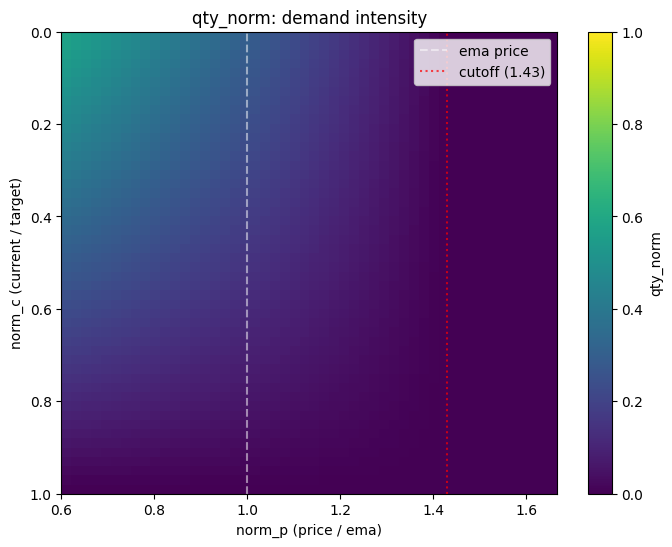

In [48]:
# Visualize qty_norm as heatmap
norm_p_range = np.linspace(PRICE_SWEEP_LOW, PRICE_SWEEP_HIGH, 50)
norm_c_range = np.linspace(0, 1, 50)  # 0% to 100% of target
P, C = np.meshgrid(norm_p_range, norm_c_range)

fig, ax = plt.subplots(figsize=(8, 6))
Z = qty_norm(P, C)
im = ax.imshow(Z, extent=[PRICE_SWEEP_LOW, PRICE_SWEEP_HIGH, 1, 0], 
               aspect='auto', cmap='viridis', vmin=0, vmax=1)
ax.axvline(1.0, color='white', linestyle='--', alpha=0.5, label='ema price')
ax.axvline(1.43, color='red', linestyle=':', alpha=0.7, label='cutoff (1.43)')
ax.set_xlabel('norm_p (price / ema)')
ax.set_ylabel('norm_c (current / target)')
ax.set_title('qty_norm: demand intensity')
ax.legend(loc='upper right')
plt.colorbar(im, ax=ax, label='qty_norm')
plt.show()

## Demand Curves at Different Stock Levels

For a fixed stock level (norm_c), sweep across prices to see the demand curve shape.

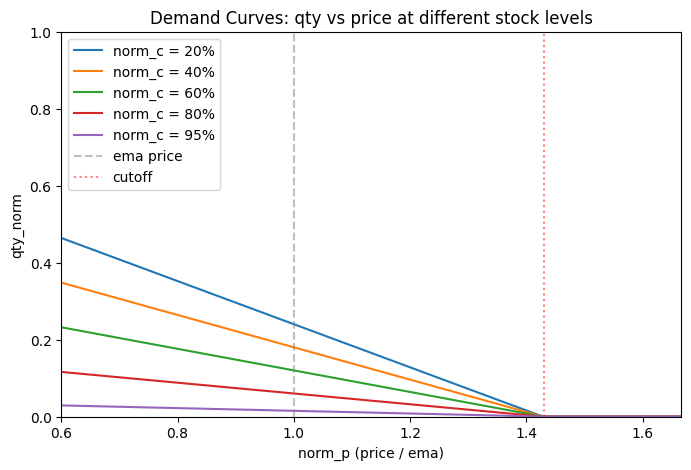

In [49]:
# Demand curves at different stock levels
fig, ax = plt.subplots(figsize=(8, 5))

prices = np.linspace(PRICE_SWEEP_LOW, PRICE_SWEEP_HIGH, 100)
stock_levels = [0.2, 0.4, 0.6, 0.8, 0.95]

for norm_c in stock_levels:
    qty = qty_norm(prices, norm_c)
    ax.plot(prices, qty, label=f'norm_c = {norm_c:.0%}')

ax.axvline(1.0, color='gray', linestyle='--', alpha=0.5, label='ema price')
ax.axvline(1.43, color='red', linestyle=':', alpha=0.5, label='cutoff')
ax.set_xlabel('norm_p (price / ema)')
ax.set_ylabel('qty_norm')
ax.set_title('Demand Curves: qty vs price at different stock levels')
ax.legend()
ax.set_xlim(PRICE_SWEEP_LOW, PRICE_SWEEP_HIGH)
ax.set_ylim(0, 1)
plt.show()

## Supply Curves (Selling when current > target)

When we have surplus, we invert both norm_p and norm_c before passing to qty_norm.
This flips the logic: high prices and high stock → sell more.

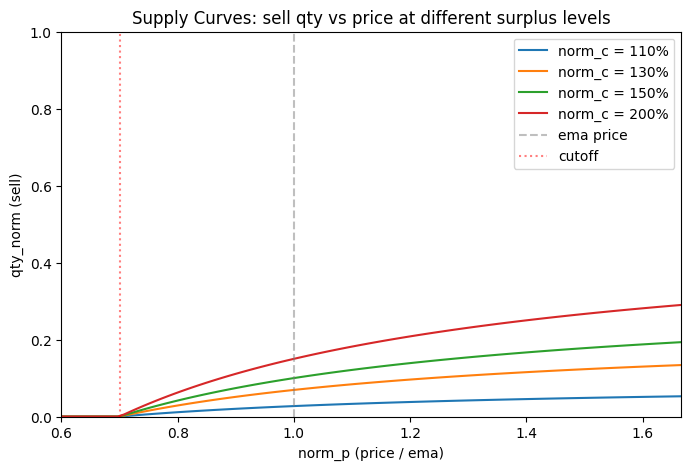

In [50]:
# Supply curves at different surplus levels
fig, ax = plt.subplots(figsize=(8, 5))

prices = np.linspace(PRICE_SWEEP_LOW, PRICE_SWEEP_HIGH, 100)
surplus_levels = [1.1, 1.3, 1.5, 2.0]  # 110%, 130%, 150%, 200% of target

for norm_c in surplus_levels:
    qty = qty_sell(prices, norm_c)
    ax.plot(prices, qty, label=f'norm_c = {norm_c:.0%}')

ax.axvline(1.0, color='gray', linestyle='--', alpha=0.5, label='ema price')
ax.axvline(0.7, color='red', linestyle=':', alpha=0.5, label='cutoff')
ax.set_xlabel('norm_p (price / ema)')
ax.set_ylabel('qty_norm (sell)')
ax.set_title('Supply Curves: sell qty vs price at different surplus levels')
ax.legend()
ax.set_xlim(PRICE_SWEEP_LOW, PRICE_SWEEP_HIGH)
ax.set_ylim(0, 1)
plt.show()

## Concrete Example: Generating Orders

Convert qty_norm to actual order quantities for a specific agent state.

In [51]:
def generate_orders(current, desired_ema, clearing_price_ema, n_price_points=10):
    """
    Generate buy or sell orders based on stockpile state.
    Returns list of (side, price, quantity) tuples.
    """
    target = desired_ema * BUFFER_TICKS
    norm_c = current / target
    
    # Sweep prices
    prices = np.linspace(
        clearing_price_ema * PRICE_SWEEP_LOW,
        clearing_price_ema * PRICE_SWEEP_HIGH,
        n_price_points
    )
    
    orders = []
    for price in prices:
        norm_p = price / clearing_price_ema
        
        if current < target:
            # Buying
            q = qty_norm(norm_p, norm_c) * desired_ema
            if q > 0.01:
                orders.append(('buy', price, q))
        else:
            # Selling
            q = qty_sell(norm_p, norm_c) * desired_ema
            if q > 0.01:
                orders.append(('sell', price, q))
    
    return orders

# Example: Food, agent is low on stock
print("=== Example: Low on food (current=20, target=100) ===")
orders = generate_orders(current=20, desired_ema=10, clearing_price_ema=5.0)
for side, price, qty in orders:
    print(f"  {side:4s} {qty:5.2f} units @ {price:.2f} (norm_p={price/5:.2f})")

print("\n=== Example: Surplus of tools (current=80, target=50) ===")
orders = generate_orders(current=80, desired_ema=5, clearing_price_ema=20.0)
for side, price, qty in orders:
    print(f"  {side:4s} {qty:5.2f} units @ {price:.2f} (norm_p={price/20:.2f})")

=== Example: Low on food (current=20, target=100) ===
  buy   4.64 units @ 3.00 (norm_p=0.60)
  buy   3.98 units @ 3.59 (norm_p=0.72)
  buy   3.31 units @ 4.19 (norm_p=0.84)
  buy   2.65 units @ 4.78 (norm_p=0.96)
  buy   1.99 units @ 5.37 (norm_p=1.07)
  buy   1.32 units @ 5.96 (norm_p=1.19)
  buy   0.66 units @ 6.56 (norm_p=1.31)

=== Example: Surplus of tools (current=80, target=50) ===
  sell  0.05 units @ 14.37 (norm_p=0.72)
  sell  0.31 units @ 16.74 (norm_p=0.84)
  sell  0.50 units @ 19.11 (norm_p=0.96)
  sell  0.65 units @ 21.48 (norm_p=1.07)
  sell  0.77 units @ 23.85 (norm_p=1.19)
  sell  0.87 units @ 26.22 (norm_p=1.31)
  sell  0.96 units @ 28.59 (norm_p=1.43)
  sell  1.03 units @ 30.96 (norm_p=1.55)
  sell  1.09 units @ 33.33 (norm_p=1.67)


## Market View: Aggregate Demand & Supply

Multiple agents with different stock levels → aggregate curves.

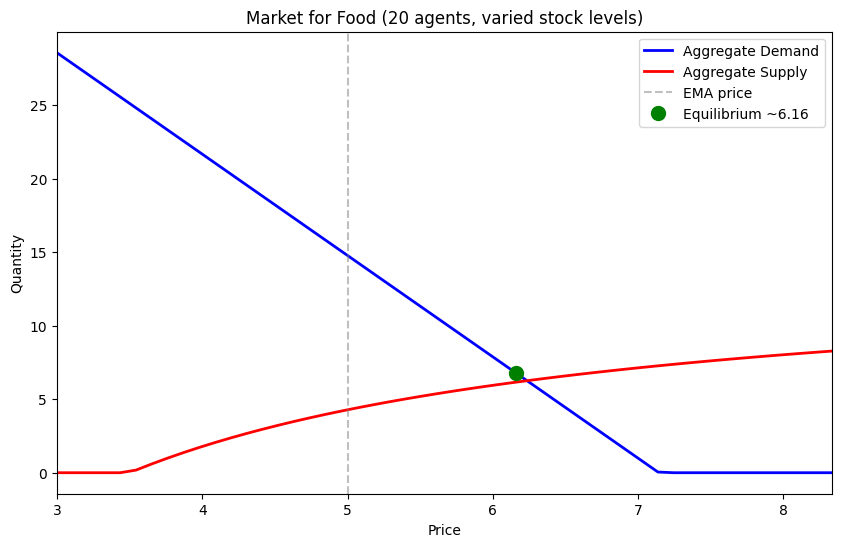

Agent stocks: min=32, max=146, mean=85
Target stock: 100
Agents below target: 12
Agents above target: 8


In [52]:
# Simulate a market with multiple agents
np.random.seed(42)

# Agent states for one good (e.g., food)
desired_ema = 10  # all agents consume ~10/tick
target = desired_ema * BUFFER_TICKS  # = 100
clearing_price_ema = 5.0

# Random stock levels: some low, some high
n_agents = 20
current_stocks = np.random.uniform(30, 150, n_agents)

# Compute demand/supply at each price point
prices = np.linspace(
    clearing_price_ema * PRICE_SWEEP_LOW,
    clearing_price_ema * PRICE_SWEEP_HIGH,
    50
)

total_demand = np.zeros_like(prices)
total_supply = np.zeros_like(prices)

for current in current_stocks:
    norm_c = current / target
    for i, price in enumerate(prices):
        norm_p = price / clearing_price_ema
        if current < target:
            total_demand[i] += qty_norm(norm_p, norm_c) * desired_ema
        else:
            total_supply[i] += qty_sell(norm_p, norm_c) * desired_ema

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(prices, total_demand, 'b-', linewidth=2, label='Aggregate Demand')
ax.plot(prices, total_supply, 'r-', linewidth=2, label='Aggregate Supply')
ax.axvline(clearing_price_ema, color='gray', linestyle='--', alpha=0.5, label='EMA price')

# Find intersection (crude)
diff = total_demand - total_supply
cross_idx = np.where(np.diff(np.sign(diff)))[0]
if len(cross_idx) > 0:
    cross_price = prices[cross_idx[0]]
    cross_qty = total_demand[cross_idx[0]]
    ax.plot(cross_price, cross_qty, 'go', markersize=10, label=f'Equilibrium ~{cross_price:.2f}')

ax.set_xlabel('Price')
ax.set_ylabel('Quantity')
ax.set_title(f'Market for Food ({n_agents} agents, varied stock levels)')
ax.legend()
ax.set_xlim(prices[0], prices[-1])
plt.show()

print(f"Agent stocks: min={current_stocks.min():.0f}, max={current_stocks.max():.0f}, mean={current_stocks.mean():.0f}")
print(f"Target stock: {target:.0f}")
print(f"Agents below target: {(current_stocks < target).sum()}")
print(f"Agents above target: {(current_stocks >= target).sum()}")